# Обработка изображений в пространственной области

Рассмотрим на практике базовые методы обработки изображений в пространственной области.

In [9]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.util import img_as_float, img_as_ubyte
from skimage import exposure
from skimage.filters import threshold_mean, threshold_otsu, threshold_local

def plot_comparison(img_original, img_filtered, img_title_filtered, img_title="Оригинал", figsize=(10, 8)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, sharex=True, sharey=True)
    ax1.imshow(img_original, cmap=plt.cm.gray)
    ax1.set_title(img_title)
    ax1.axis('off')
    ax2.imshow(img_filtered, cmap=plt.cm.gray)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

## Попиксельные операции

### Пример 1. Усреднение зашумлённых изображений одного объекта для уменьшения шума. 

Предположим у нас есть последовательность изображений одного и того же объекта, c шумовой компонентой:

$J_i = I + \eta_i, \quad i=1,\dots,L.$

Здесь $\eta_i$ для каждого пикселя $(m,n)$ это значение случайной величины с нулевым средним. Полагаем, что эти величины независимы или не коррелируют друг с другом. При сделанных предположениях для усреднённого изображения

$J_{new} = \frac 1L \sum\limits_{i=1}^L J_i$

можно найти 

Математическое  ожидание: $ E[J_{new}(m,n)] = I(m,n)$

Стандартное отклонение: $ \sigma_{J_{new}(n,m)} = \frac{1}{\sqrt{L}} \sigma_{\eta(n,m)}$.

То есть с увеличением $L$, величина отклонения уменьшается, а значит усреднённое изображение приближается к $I$. Тем самым достигается уменьшение шума. Это полезно в астрономии, где  изображение получается при очень малом уровне освещенности и значит при высоком уровне шума датчика, что зачастую делает отдельные снимки почти бесполезными для анализа

In [3]:
im_orig = img_as_float(plt.imread('./source/galaxy.tif'))
size = im_orig.shape

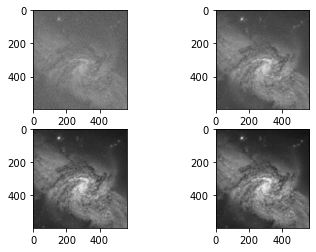

In [4]:
im_noise = im_orig + 0.25*np.random.randn(*size)

im_10avg = np.array([im_orig + 0.25*np.random.randn(*size) for  i in range(10)])
im_10avg = np.mean(im_10avg, axis = 0)

im_50avg = np.array([im_orig + 0.25*np.random.randn(*size) for  i in range(50)])
im_50avg = np.mean(im_50avg, axis = 0)

im_100avg = np.array([im_orig + 0.25*np.random.randn(*size) for  i in range(100)])
im_100avg = np.mean(im_100avg, axis = 0)

plt.subplot(221)
plt.imshow(im_noise, cmap=plt.cm.gray)
plt.subplot(222)
plt.imshow(im_10avg, cmap=plt.cm.gray)
plt.subplot(223)
plt.imshow(im_50avg, cmap=plt.cm.gray)
plt.subplot(224)
plt.imshow(im_100avg, cmap=plt.cm.gray)

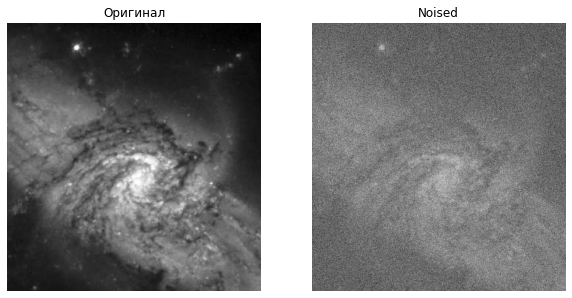

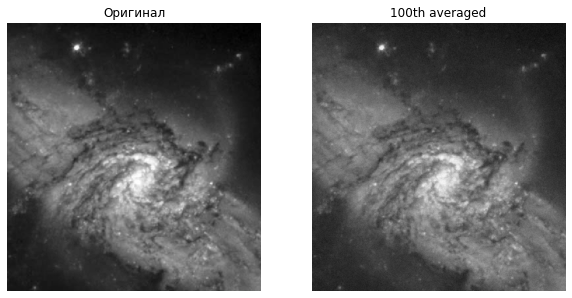

In [5]:
plot_comparison(im_orig, im_noise, "Noised")    
plot_comparison(im_orig, im_100avg, "100th averaged")

### Пример 2. Обнаружение различий в изображениях.

Для выявления различий в изображениях можно использовать обычную разность между массивами пикселей.

Ниже представлено два изображения, одно оригинальное, второе модифицированное, которое получено из оригинального изменением значений некоторых пикселей. Чтобы найти эти пиксели, можно вычесть из одного изображения другое.

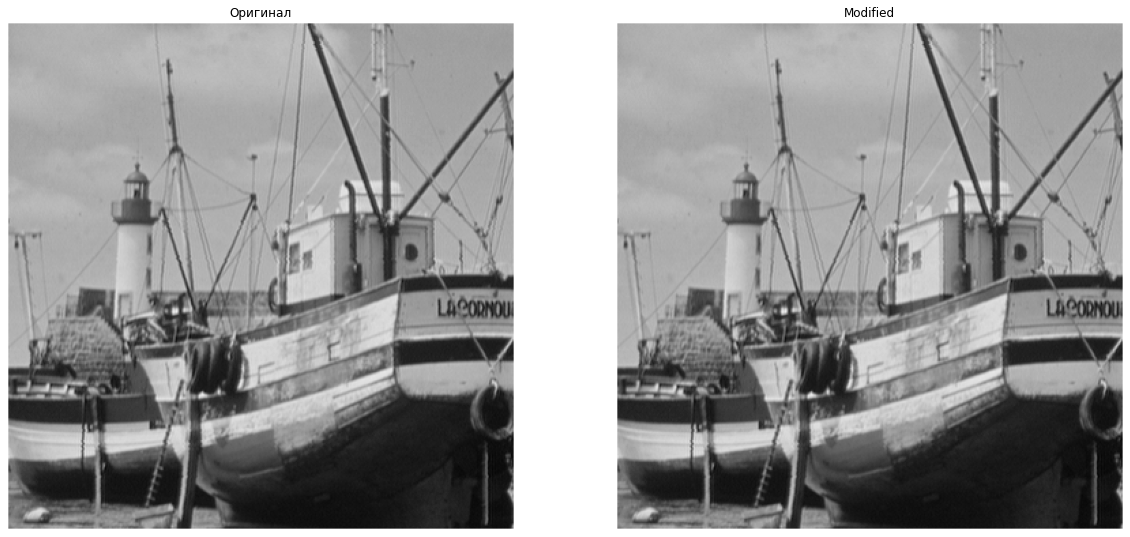

In [10]:
from skimage.color import rgb2gray
from skimage.util import img_as_float, img_as_ubyte

im_orig = plt.imread('./source/ship_orig.bmp')
im_mod = plt.imread('./source/ship_mod.bmp')

plot_comparison(im_orig, im_mod, "Modified", figsize=(20,16))    

In [85]:
#plt.figure(figsize=(32, 32))
#plt.imshow(im_mod, cmap='gray')

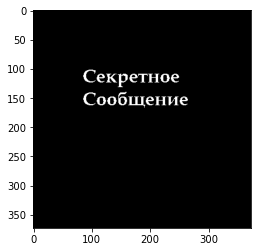

In [11]:
im_diff = im_mod - im_orig
plt.imshow(im_diff, cmap='gray')

### Пример 3. Маскирование

Маскирование изображение иными словами - это выделение в изображении области интереса. Процесс состоит просто в умножении данного изображения на изображение-маску, пиксели которого имеют значение 1 в области интереса и значение 0 в прочих местах.

Ниже в примере создаётся маска, у который пиксели со значением 1 соответствуют пикселям в исходном изображении со значениями больше, чем 128.

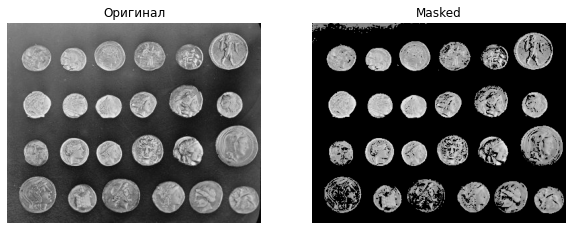

In [12]:
image = data.coins()
mask = image > 128
masked_image = image * mask

plot_comparison(image, masked_image, "Masked")    

## Манипуляция с гистограммой

### Функции преобразования яркости

Для применения функций преобразования яркости в библиотеке `skimage` можно использовать методы пакета `exposure`:

    `adjust_gamma()` для гамма-коррекции
    `adjust_log()` для логарифмического преобразования
    
Применим эти методы на примере изображения поверхности Луны.

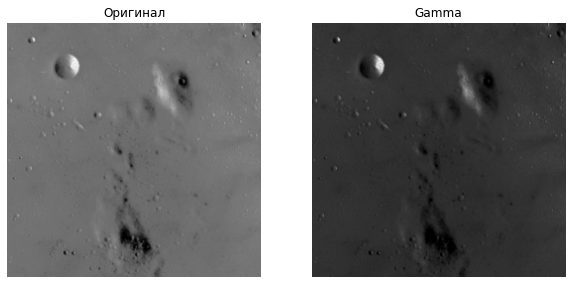

In [13]:
image = data.moon()
gamma = 2
gamma_corrected = exposure.adjust_gamma(image, gamma)
# При gamma>1 результат темнее
plot_comparison(image, gamma_corrected, 'Gamma')

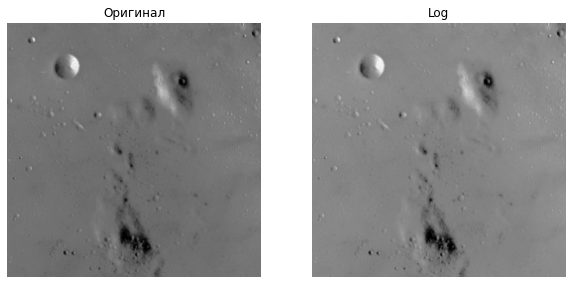

In [14]:
image = data.moon()
log_corrected = exposure.adjust_log(image)
# При логарифмировании результат чуть светлее
plot_comparison(image, log_corrected, 'Log')

### Гистограмма

Рассмотрим задачу усиления контраста изображения. Многие источники изображений генерируют изображения с "плохим" констрастом. Например, таковы рентгеновские изображения.

Контраст зависит от динамического диапазона изображения, то есть разница между максимальной и минимальной яркостью пикселей изображения.
Изображения с плохим контрастом имеют малую разность между темными и светлыми пикселями. Для исправления контраста используется гистограмма - график, где аргументы - это значения от 0 до 255, а значения - это число пикселей с соответствующей яркостью.

Под улучшением контраста понимается растяжение гистограммы на весь доступный диапазон и выравнивание гистограммы.
 
    - Histogram equalization
    - Adaptive histogram equalization
    - Contrast Limited Adaptive Histogram Equalization (CLAHE)

Для выравнивания гистограммы (Histogram equalization) можно использовать модуль `exposure` из библиотеки `skimage`. 
Там есть метод и для классического выравнивания гистограммы, так и для адаптивного.

Для работы с гистограммой в библиотеке `skimage` можно использовать методы пакета `exposure`:

    `histogram()` вернуть массив со значениями гистограммы
    `cumulative_distribution()` вычислить функцию распределения
    
Найдём и отрисуем гистограмму на примере изображения поверхности Луны.

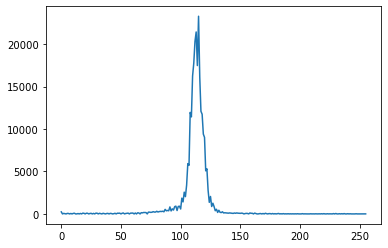

In [5]:
image = data.moon()
hist, bins = exposure.histogram(image, nbins=256)
plt.plot(bins, hist)

Найдём также функцию распределения яркостей пикселей на примере изображения поверхности Луны.
Отобразим этот график вместе с графиком гистограммы.

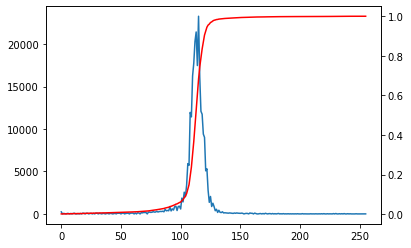

In [6]:
img_cdf, bins = exposure.cumulative_distribution(image, 256)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # ось для второго графика, при этом значения по оси-x одинаковые.

ax1.plot(bins, hist)
ax2.plot(bins, img_cdf, 'r')

plt.show()

Для выравнивания гистограммы можно использовать метод `equalize_hist()` из пакета `exposure`.

Продемонстрируем работу этого метода на примере.

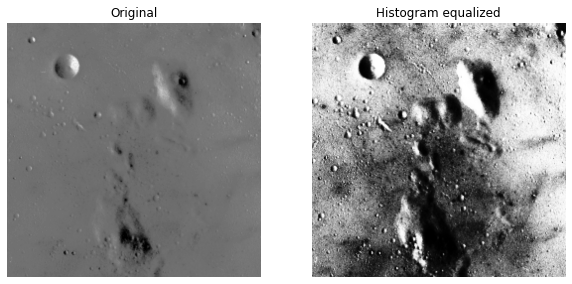

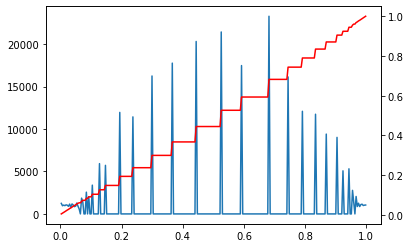

In [17]:
# Выравнивание
img_eq = exposure.equalize_hist(image)

plot_comparison(image, img_eq, 'Histogram equalized')

hist2, bins = exposure.histogram(img_eq, nbins=256)
img_cdf2, bins = exposure.cumulative_distribution(img_eq, 256)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # ось для второго графика, при этом значения по оси-x одинаковые.

ax1.plot(bins, hist2)
ax2.plot(bins, img_cdf2, 'r')

plt.show()

Действительно изображение стало более контрастным. И даже слишком. Более лучший визуальный результат можно получить с помощью адаптивного метода выравнивания гистограммы CLAHE.

Для выравнивания гистограммы можно использовать метод `equalize_adapthist()` из пакета `exposure`.

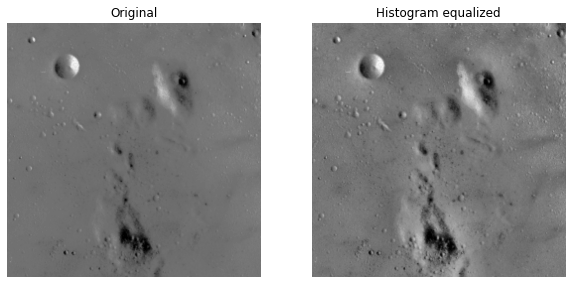

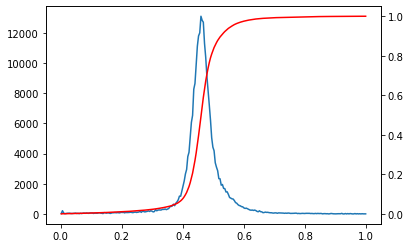

In [18]:
# Адаптивное выравнивание
img_eq = exposure.equalize_adapthist(image)

plot_comparison(image, img_eq, 'Histogram equalized')

hist2, bins = exposure.histogram(img_eq, nbins=256)
img_cdf2, bins = exposure.cumulative_distribution(img_eq, 256)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # ось для второго графика, при этом значения по оси-x одинаковые.

ax1.plot(bins, hist2)
ax2.plot(bins, img_cdf2, 'r')

plt.show()

Приведём ещё несколько примеров выравнивания гистограммы.

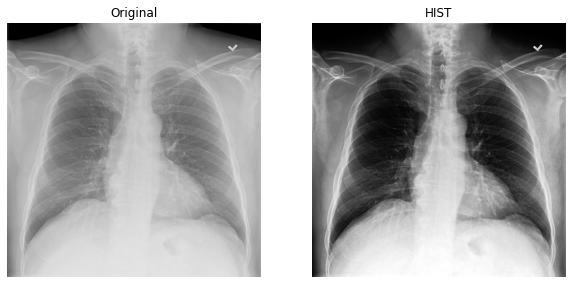

In [42]:
from skimage import exposure

image_aerial = plt.imread('./source/chest_xray_image.png')

# Use histogram equalization to improve the contrast
image_eq = exposure.equalize_hist(image_aerial)

plot_comparison(image_aerial, image_eq, "HIST")


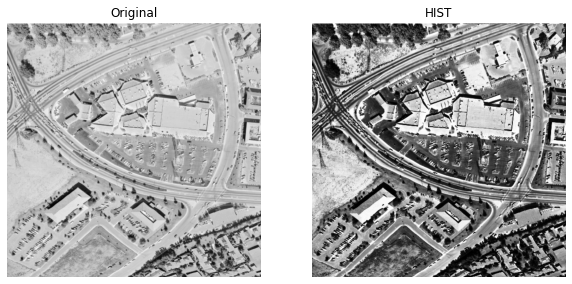

In [43]:
from skimage import exposure

image_aerial = plt.imread('./source/arial_image.png')

# Use histogram equalization to improve the contrast
image_eq = exposure.equalize_hist(image_aerial)

plot_comparison(image_aerial, image_eq, "HIST")

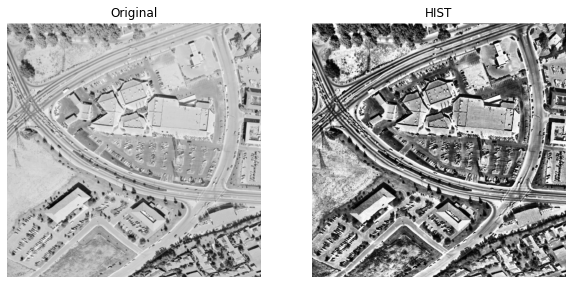

In [44]:
image_adapteq = exposure.equalize_adapthist(image_aerial, clip_limit=0.03)
plot_comparison(image_aerial, image_adapteq, "HIST")

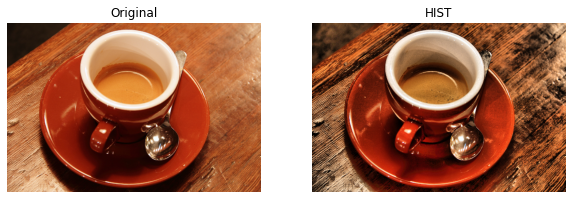

In [45]:
from skimage import data

# Load the image 
original_image = data.coffee()
# Apply the adaptive equalization on the original image
adapthist_eq_image = exposure.equalize_adapthist(original_image, clip_limit=0.03)
plot_comparison(original_image, adapthist_eq_image, "HIST")

### Бинаризация

Для бинаризации изображений в библиотеке `skimage` можно использовать методы пакета `filter`:

    `threshold_mean()` вернуть глобальный порог, равный среднему значению в изображении
    `threshold_otsu()` вернуть глобальный порог по Методу Отсу

Сама бинаризация при этом проводится с помощью маски.

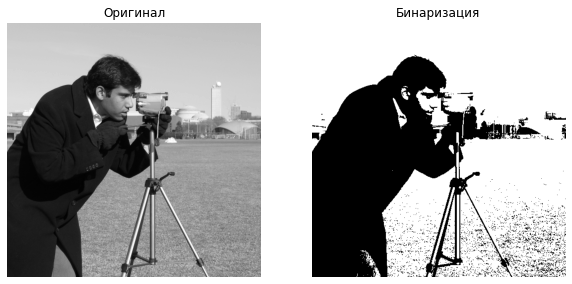

In [7]:
image = data.camera()
thresh = threshold_mean(image)
binary = image > thresh

plot_comparison(image, binary, 'Бинаризация по среднему')

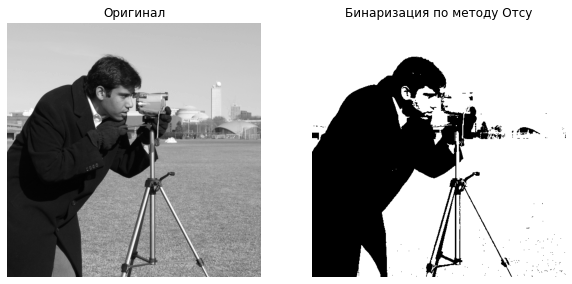

In [11]:
image = data.camera()
thresh = threshold_otsu(image)
binary = image > thresh

plot_comparison(image, binary, 'Бинаризация по методу Отсу')

Однако, бинаризация по глобальному порогу не всегда даёт приемлимый результат. Адаптивная бинаризация является более гибким подходом. Для этого можно использовать метод `threshold_local()`, указывая в параметрах размер окрестности, метод вычисления и прочие параметры.

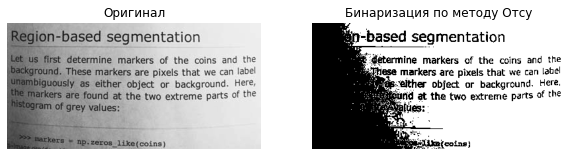

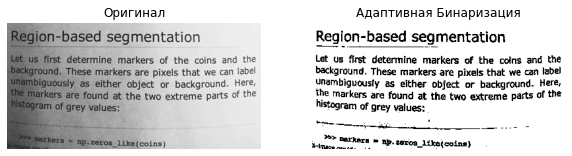

In [21]:
image = data.page()

global_thresh = threshold_otsu(image)
binary_global = image > global_thresh

block_size = 35
local_thresh = threshold_local(image, block_size, offset=10)
binary_local = image > local_thresh

block_size = 35
local_thresh2 = threshold_local(image, block_size, method='mean', offset=10)
binary_local_mean = image > local_thresh2

plot_comparison(image, binary_global, 'Бинаризация по методу Отсу')
plot_comparison(image, binary_local_mean, 'Адаптивная Бинаризация')

# Линейная фильтрация

## Основные методы

Рассмотрим примеры фильтрации изображений.

В библиотеке `skimage` нет специальной функции для проведения свёртки. Однако, эта библиотека является расширением библиотеки `scipy`, в которой свёртка есть в пакете `ndimage`, метод `convolve()`. В этом методе есть несколько способов того, как считать свёртку для значений на границе изображения, для этого нужно указать параметр `mode`:

    mode=‘reflect’ значит, что пиксели будут отражены, как в зеркале, по границе изображения, то есть (d c b a | a b c d | d c b a), это является значением по умолчанию.
    mode=‘constant’ значит, что пиксели за границей будут равны константе, по умолчанию нулю.
    mode=‘mirror’ значит, что пиксели будут отражены от граничного пикселя, то есть(d c b | a b c d | c b a)

Пример применения продемонстрирован ниже.

Подгрузим сразу все необходимые пакеты и методы.

In [28]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import filters
from skimage import data
from skimage import color
from skimage import exposure

def plot_comparison(img_original, img_filtered, img_title_filtered, img_title="Оригинал", figsize=(10, 8)):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=figsize, sharex=True, sharey=True)
    ax1.imshow(img_original, cmap=plt.cm.gray)
    ax1.set_title(img_title)
    ax1.axis('off')
    ax2.imshow(img_filtered, cmap=plt.cm.gray)
    ax2.set_title(img_title_filtered)
    ax2.axis('off')

In [23]:
signal = np.array([[1.0, 2, 0, 0],
              [5, 3, 0, 4],
              [0, 0, 0, 7],
              [9, 3, 0, 0]])

h = np.ones((3,3))/9

ndimage.convolve(signal, h, mode='constant', cval=0.0)

array([[1.22222222, 1.22222222, 1.        , 0.44444444],
       [1.22222222, 1.22222222, 1.77777778, 1.22222222],
       [2.22222222, 2.22222222, 1.88888889, 1.22222222],
       [1.33333333, 1.33333333, 1.11111111, 0.77777778]])

Таким образом, для применения той или иной ЛС-системы к изображению, то есть для линейной фильтрации, надо лишь задать походящий фильтр, то есть импульсную характеристику h.

Однако, в библиотеке `skimage` в пакете `filters` есть методы для применения к изображению наиболее часто используемымх фильтров.

### НЧ фильтрация: сглаживание

#### Фильтр Гаусса

Рассмотрим фильтр Гаусса для сглаживания изображений, который представляет собой дискретизацию гауссианы. 

В пакете `skimage.filters` применение соответствующего фильтра вызвается методом `gaussian()`.
На вход первым аргументом подаётся изображение. 

Также есть набор параметров. Например, можно указать флаг, является ли изображение цветным `multichannel=True`. 
Параметр `sigma=1` отвечает за "силу" размытия

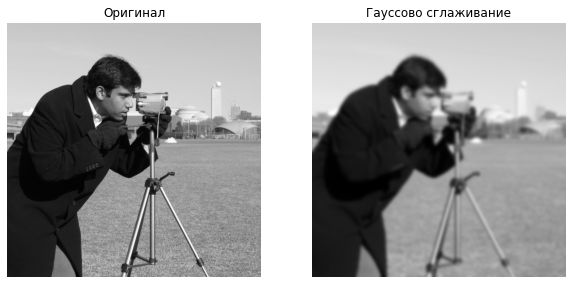

In [25]:
image = data.camera()
filtered_img = filters.gaussian(image, sigma=3)
plot_comparison(image, filtered_img, "Гауссово сглаживание")

### ВЧ фильтрация: детекция границ

ВЧ фильтры позволяют выделять границы в изображении. 

Базовая идея обнаружения границ: найти резкие скачки функции яркости в изображении. 

Однимиз простейших ВЧ фильтров является фильтр Лапласа.

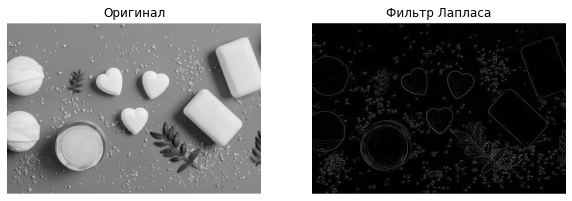

In [26]:
image = plt.imread('./source/soap_image.png')

# К изображению в серых тонах
image_gray = color.rgb2gray(color.rgba2rgb(image))
# применение фильтра Лапласа
image_filt = filters.laplace(image_gray, ksize=3)

plot_comparison(image_gray, exposure.equalize_adapthist(image_filt), "Фильтр Лапласа")

### Фильтры Баттерворта

Для применения фильтров Баттерворта можно использовать метод `butterworth(image, cutoff_frequency_ratio=0.005, high_pass=True, order=2.0, channel_axis=None)`

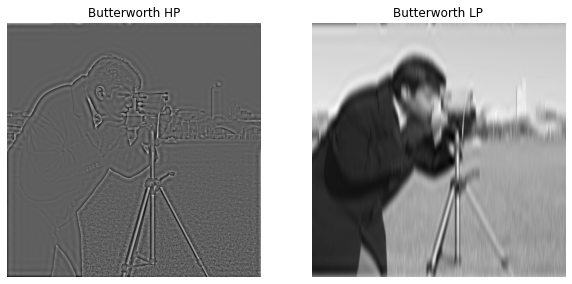

In [29]:
high_pass = filters.butterworth(data.camera(), 0.07, True, 8)
low_pass = filters.butterworth(data.camera(), 0.03, False, 4, channel_axis=-1)
plot_comparison(high_pass, low_pass, "Butterworth LP", img_title = "Butterworth HP")

Фильтрацию можно осуществлять в частотной области. По сути мы это проделали в одном из предыдущих ноутбуков, когда очищали изображения от специального типа шума. Надо применить ДПФ к изображению, изменить те или иные частоты тем или иным образом. Затем проделать обратное ДПФ.

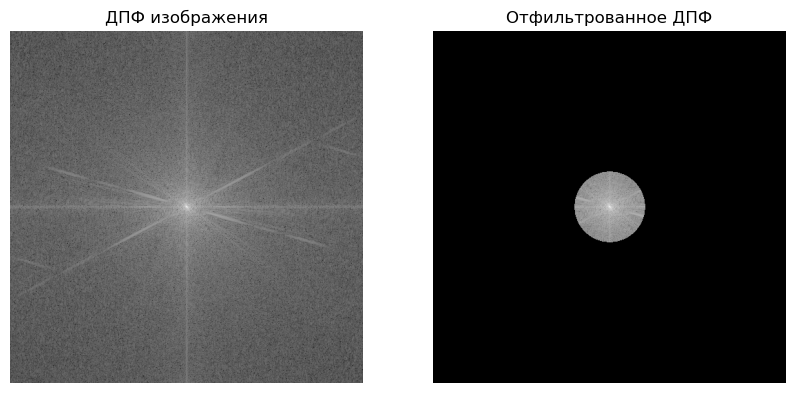

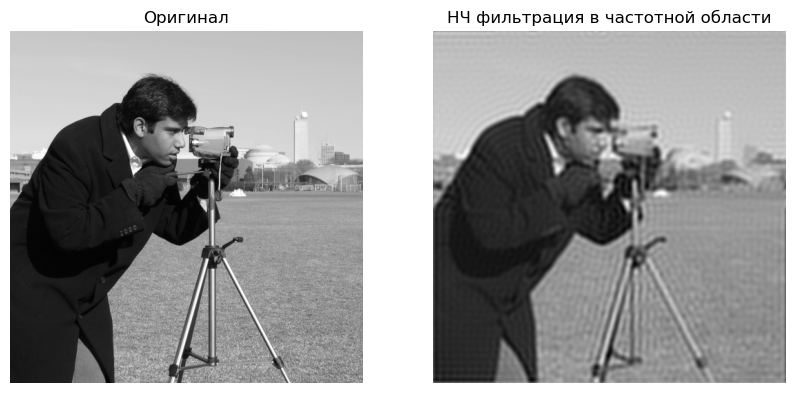

In [16]:
from scipy.fftpack import fft2, fftshift, ifft2
from skimage import data
import matplotlib.pyplot as plt
import numpy as np

im = data.camera()

im_fft = fft2(im)
im_fft = fftshift(im_fft)

# Число строк, столбцов
r, c = im_fft.shape

# квадратная маска
keep_coef = 0.09
mask = np.zeros((r,c))
r1 = int(keep_coef*r)
c1 = int(keep_coef*c)
mask[int(r/2-r1):int(r/2+r1+1),int(c/2-c1):int(c/2+c1+1)] = 1

# круглая маска
mask = np.zeros((r,c))
rad = 0.10 * r
for i in range(r):
    for j in range(c):
        if (i-r/2)**2+(j-c/2)**2 < rad**2:
            mask[i,j] = 1

im_fft2 = im_fft*mask
im_new = ifft2(fftshift(im_fft2)).real

plot_comparison(np.log(1+np.abs(im_fft)), np.log(1+np.abs(im_fft2)), "Отфильтрованное ДПФ", img_title = "ДПФ изображения")

plot_comparison(im, im_new, "НЧ фильтрация в частотной области", img_title = "Оригинал")


### Нелинейная фильтрация

В пакете skimage.filters метод median() позволяет применить медианный фильтр к изображению

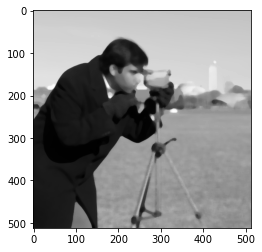

In [18]:
from skimage import data
from skimage.morphology import disk
from skimage.filters import median
img = data.camera()
med = median(img, disk(5))
plt.imshow(med, cmap='gray')

## Приложения фильтрации

### Подавление шума

Рассмотрим пример подавления шума в изображении с помошью усредняющего и медианного фильтров.

Сначала рассмотрим изображение, в котором 1% пикселей случайно становится равным 0, и ещё 1% случайно становится равным 255.

Классической метрикой для измерения шума в изображениях является PSNR (Peak Signal-To-Noise Ratio). Это соотношение между максимумом возможного значения сигнала и мощностью шума, искажающего значения сигнала. Поскольку многие сигналы имеют широкий динамический диапазон, PSNR обычно измеряется в логарифмической шкале в децибелах. 

$$
PSNR_{db} = 20 \log_{10} \left( \frac{MAX_{sig}}{RMSE}\right),
$$

где $MAX_{sig}$ в нашем случае равно 255, а RMSE

$$
RMSE = \sqrt{\frac{1}{N M} \sum_{i=1}^N \sum_{j=1}^M |I_{orig}(i,j) - I_{noised}(i,j)|^2}
$$

PSNR для зашумлённого:  21.695478763323667
PSNR для очищенного от шума:  32.45948212131337


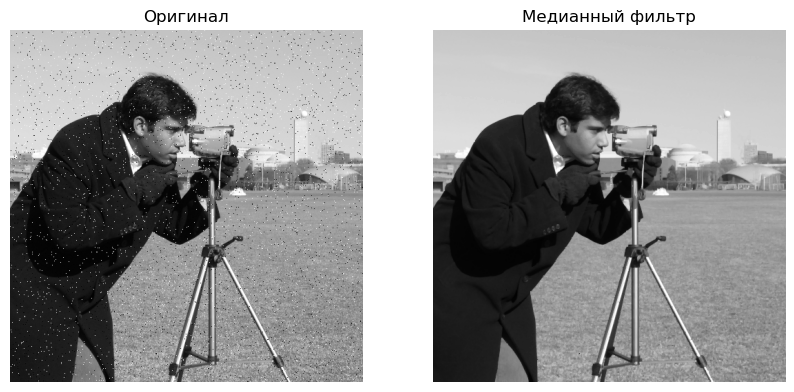

In [24]:
from skimage.filters.rank import median, mean
from skimage.morphology import disk, ball
from skimage.util import img_as_ubyte, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr

noisy_image = img_as_ubyte(data.camera())
noise = np.random.random(noisy_image.shape)
noisy_image[noise > 0.99] = 255
noisy_image[noise < 0.01] = 0
# тут на вход uint надо
denoised = median(noisy_image, disk(1))

plot_comparison(noisy_image, denoised, "Медианный фильтр")

print("PSNR для зашумлённого: ", psnr(img_as_ubyte(data.camera()),noisy_image))

print("PSNR для очищенного от шума: ", psnr(img_as_ubyte(data.camera()),denoised))

PSNR:  25.922924495830934


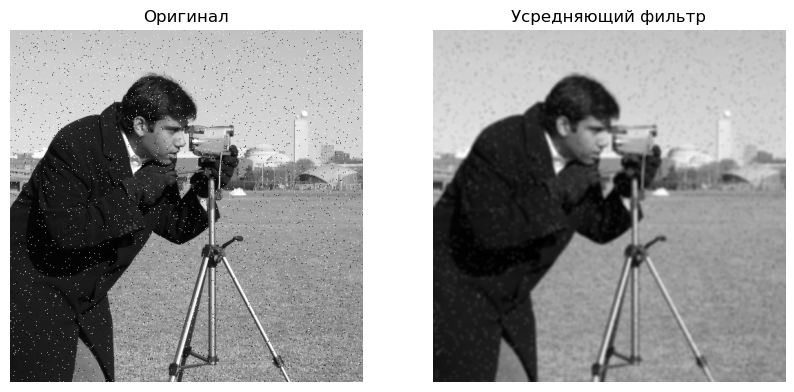

In [22]:
denoised2 = mean(noisy_image, disk(3))
plot_comparison(noisy_image, denoised2, "Усредняющий фильтр")
print("PSNR для очищенного от шума: ", psnr(img_as_ubyte(data.camera()),denoised2))

Для этого типа шума медианный фильтр показывает себя гораздо более эффективным.

Далее, рассмотрим гауссов белый шум.

PSNR для зашумлённого:  22.40211097547101


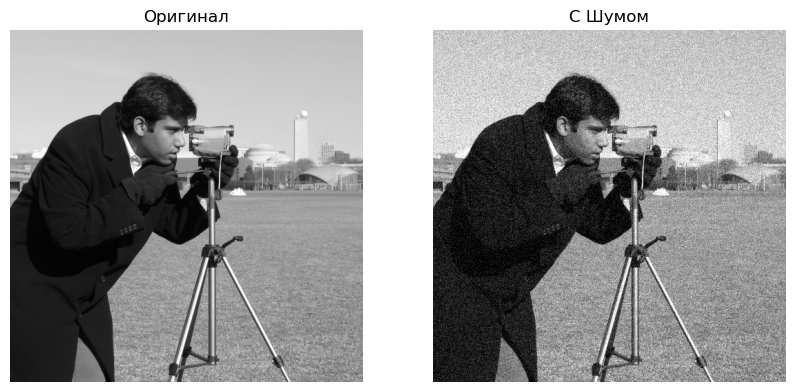

In [28]:
image = img_as_ubyte(data.camera())

image_noise = image + 20 * np.random.randn(*image.shape)
image_noise[image_noise>255] = 255
image_noise[image_noise<0] = 0
image_noise = np.uint8(image_noise)
plot_comparison(image, image_noise, "С Шумом")

print("PSNR для зашумлённого: ", psnr(image,image_noise))

PSNR для зашумлённого:  26.779433765998984


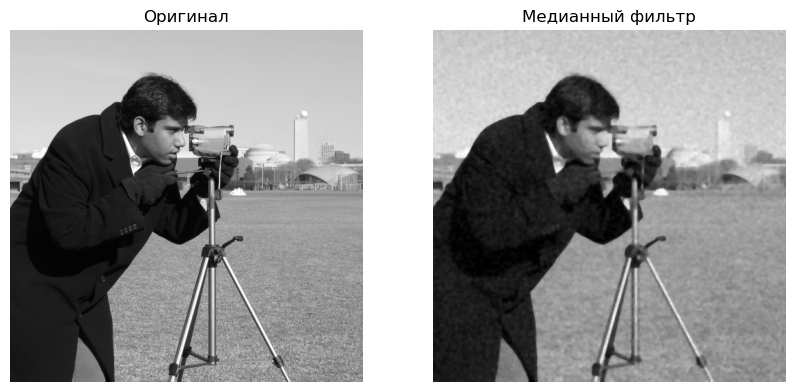

In [29]:
denoised = median(image_noise, disk(3))
plot_comparison(image, denoised, "Медианный фильтр")

print("PSNR для зашумлённого: ", psnr(image,denoised))

PSNR для зашумлённого:  25.995916047239483


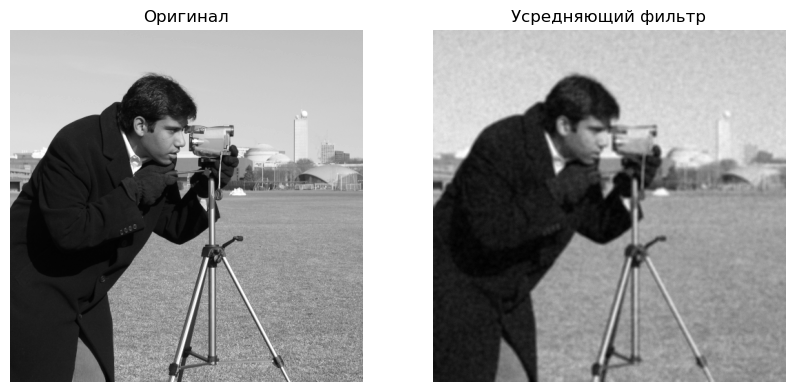

In [30]:
denoised2 = mean(image_noise, disk(3))
plot_comparison(image, denoised2, "Усредняющий фильтр")

print("PSNR для зашумлённого: ", psnr(image,denoised2))

### Увеличение резкости

Для увеличения резкости используется метод unsharp_mask()

Есть два параметра: радиус размытия и сила усиления. Размытие проводится с помощью гауссова фильтра

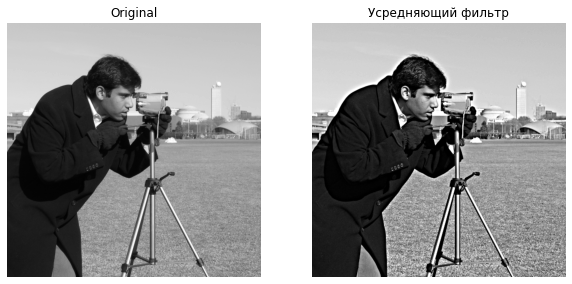

In [68]:
image = data.camera()
image_unsharp = filters.unsharp_mask(image, radius=5, amount=1)

plot_comparison(image, image_unsharp, "Усредняющий фильтр")

### Дететктирование границ

#### Оператор Собеля

Простейшим фильтром для выделения границ является фильтр Собеля.
В библиотеке `skimage.filters` соответствующий фильтр называется `sobel`.
На вход 2D массив, то есть изображение в серых тонах 

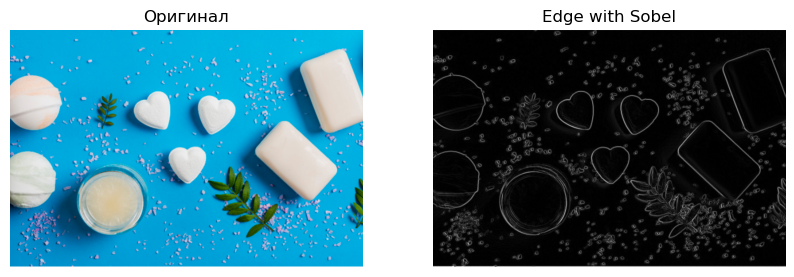

In [33]:
from skimage import filters
from skimage import color

# Загрузим изобажение и переведём в серое изображение
soaps_image = plt.imread('./source/soap_image.png')
soaps_image_gray = color.rgb2gray(color.rgba2rgb(soaps_image))

# применить фильтр Собеля
edge_sobel = filters.sobel(soaps_image_gray)

plot_comparison(soaps_image, edge_sobel, "Фильтр Собеля")

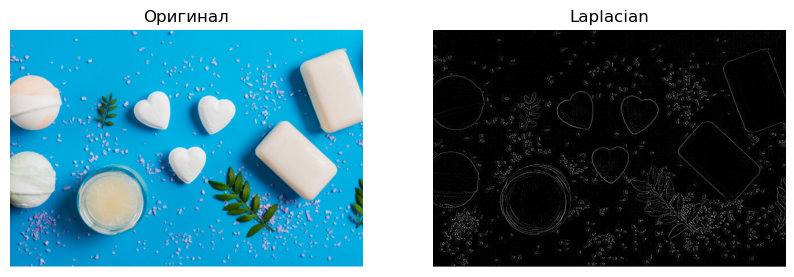

In [41]:
# применение фильтра Лапласа
image_filt = filters.laplace(soaps_image_gray, ksize=3)

plot_comparison(soaps_image, exposure.equalize_adapthist(image_filt), "Фильтр Лапласа")
#plt.imshow(exposure.equalize_adapthist(image_filt), cmap = 'gray')

##  Трансформации изображения

Трансформация или поворот изображения часто требуются в таких задачах, как

- подготовка изображений для задач машинного обучения
- оптимизация или сжатие изображений
- формирование датасета изображений с одни и тем же разрешением.

Методы для этих операций есть в модуле `transform` библиотеки `scikit-image`.

Например, для поворота изображения можно использовать метод `rotate()`.
Первый аргумент - это изображение. Второй - это поворот на сколько градусов (по умолчанию повороты против часовой стрелки). 

Для смены разрешения можно использовать метод `rescale()`. Также есть три параметра: первый - коэффициент dowm-sampling. Второй - это применять ли антиалиасинговый фильтра перед dowm-sampling.  Третий - это цветное ли изображение. 

Появление при такой операции алиасинга обсуждалось в одной из лекций. Без фильтрации также изображение выглядит более пикселизированным и можно проявиться эффект наложения частот.

Ещё один метод для смены разрешения - это метод `resize()` В нём можно явно задать итоговое разрешение изображения:

    `image_resized = resize(image, (height, width), anti_aliasing=True)`

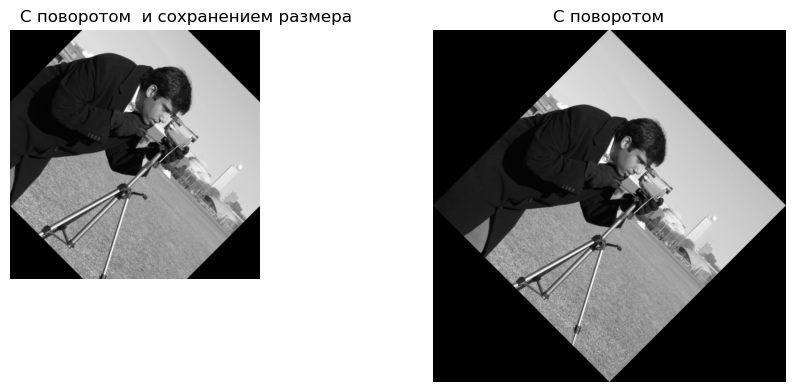

In [51]:
from skimage.transform import rotate, rescale
from skimage import data


im = data.camera()
# Поворот на 45 по часовой
rotated_im = rotate(im, -45)
rotated_im2 = rotate(im, -45, resize = True)

plot_comparison(rotated_im, rotated_im2, "С поворотом", img_title = 'С поворотом  и сохранением размера')

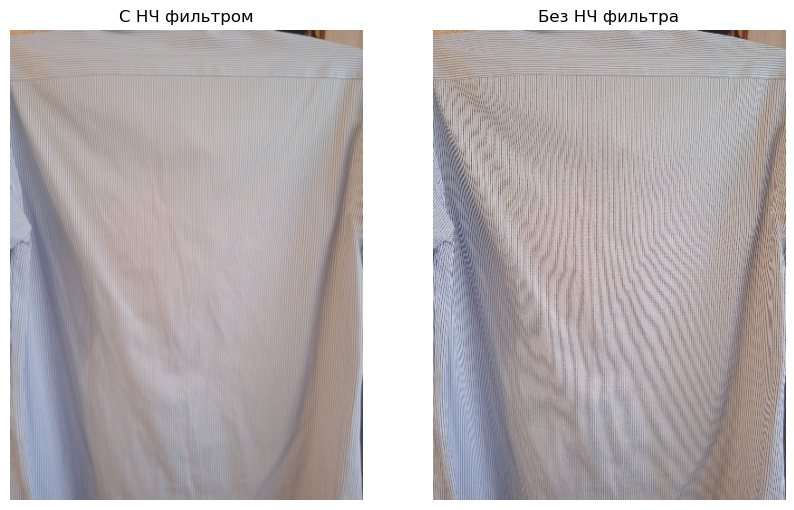

In [55]:
from skimage.transform import rotate, rescale

im = plt.imread('./source/Alias.jpg')

# Смена разрешения с НЧ фильтром
rescaled_with_aa = rescale(im, 1/8, anti_aliasing=True, channel_axis=2)
# Смена разрешения без НЧ фильтра, то есть просто down-sampling
rescaled_without_aa = rescale(im, 1/8, anti_aliasing=False, channel_axis=2)

plot_comparison(rescaled_with_aa, rescaled_without_aa, "Без НЧ фильтра", img_title = 'С НЧ фильтром')

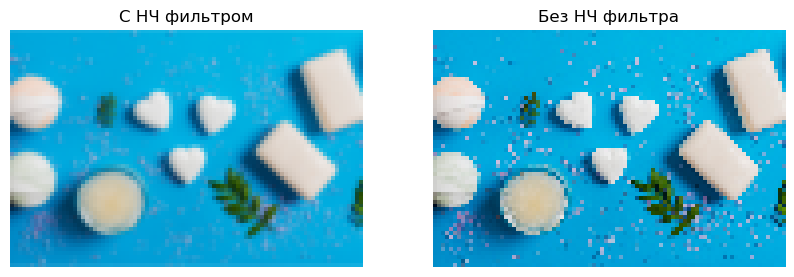

In [56]:
im = plt.imread('./source/soap_image.png')

# Смена разрешения с НЧ фильтром
rescaled_with_aa = rescale(im, 1/8, anti_aliasing=True, channel_axis=2)
# Смена разрешения без НЧ фильтра, то есть просто down-sampling
rescaled_without_aa = rescale(im, 1/8, anti_aliasing=False, channel_axis=2)

plot_comparison(rescaled_with_aa, rescaled_without_aa, "Без НЧ фильтра", img_title = 'С НЧ фильтром')